# Mars Landing Site Identification
MAT 494, Spring 2023

### Base setup

In [54]:
# base libraries
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import json
import pickle

# note: cv2 is deprecated, and opencv doesn't appear to install on the conda forge registry?
import cv2

In [2]:
import imageio
from skimage.segmentation import chan_vese

In [3]:

import rasterio
import cartopy.crs as ccrs
from rasterio import features
import shapely
from trimesh.path.polygons import sample

### Data loading

In [4]:
# file paths
# OFFICIAL resolution: (2880, 5760)
elev_file ="test_data/megt90n000fb.img"
dust_file = "test_data/dci_lo_ice_dust_16ppd_shifted.raw"
TI_file = "test_data/ti16"
alb_file = "test_data/alb32"
tes_file = "test_data/TES_Glass_Clay_numeric"

In [5]:
def load_elevation(file):
    with open(file,"rb") as f:
        dat = f.read()
        z=np.frombuffer(dat, dtype='>i2').reshape(720*8,1440*8).astype(np.float64)
        
    return z

In [6]:
def load_dci(file):
    with open(file,"rb") as f:
        dat = f.read()
    dci = np.frombuffer(dat,dtype=np.float32).reshape(2880,5760)
    return dci

In [7]:
def load_TI(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    ti = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.int32).reshape(1440,2880)
    return ti

In [8]:
def load_alb(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    alb = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(1440,2880)
    return alb

In [9]:
def load_TES(file, VICAR_LBLSIZE=5760):
    with open(file,"rb") as f:
        dat = f.read()
    TES = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(720,1440)
    return TES

In [10]:
def roll_dci(dci, ROLL=2880):
    return np.roll(dci, ROLL, axis=1)

In [11]:
def downsample_elevation(elev):
    return elev[0::2,0::2]

In [12]:
def scale_up(arr):
    h,w = arr.shape[:2]
    # Nearest Neighbor interpolation
    new_arr = np.zeros((h*2, w*2))
    
    new_arr[0::2,0::2] = arr
    new_arr[1::2,0::2] = arr
    new_arr[0::2,1::2] = arr
    new_arr[1::2,1::2] = arr
    
    return new_arr

In [13]:
# Load Files
elev = load_elevation(elev_file)
dci = load_dci(dust_file)
ti = load_TI(TI_file)
alb = load_alb(alb_file)
TES = load_TES(tes_file)

# Pre Process
elev = downsample_elevation(elev)
dci = roll_dci(dci)
ti = scale_up(ti)
alb = scale_up(alb)
TES = scale_up(scale_up(TES))

assert elev.shape == dci.shape == ti.shape == alb.shape == TES.shape

In [14]:
elev[0::2,0::2].shape

(1440, 2880)

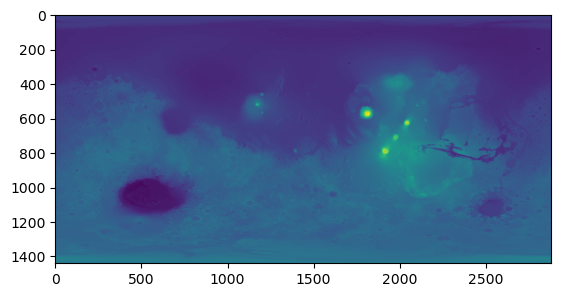

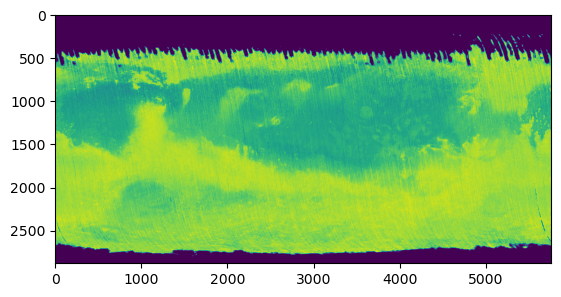

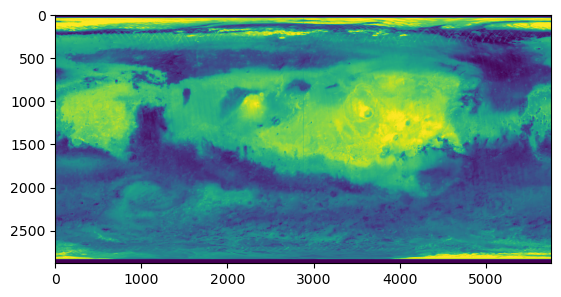

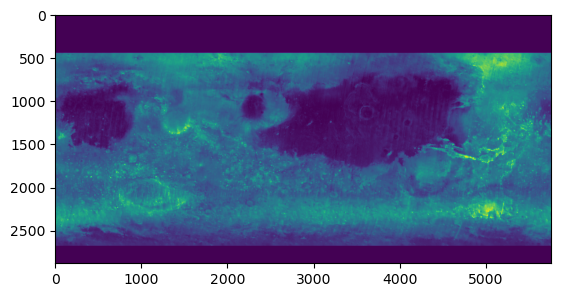

In [15]:
plt.imshow(elev[0::2,0::2])
plt.show()
plt.imshow(dci)
plt.show()
plt.imshow(alb)
plt.show()
plt.imshow(ti)
plt.show()

In [16]:
elev<0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

np.frombuffer(dat).reshape(5760,2880)

In [17]:
33177600/5760

5760.0

### Constraint identification

In [18]:
# setting up conditions
# elevation (km)
min_elev = -(math.inf)
max_elev = -1.3

# thermal inertia (TI)
min_ti = 200
max_ti = 250
# min_ti = 1
# max_ti = math.inf

# albedo
min_alb = 0.18
max_alb = 0.26

# dust cover index (DCI)
min_dci = 0.93
max_dci = 0.97

### Filters

#### Boolean filters

In [19]:
# boolean filtering
elev_mask = [(elev > min_elev) & (elev <= max_elev)][0]
ti_mask = [(ti > min_ti) & (ti <= max_ti)][0]
alb_mask = [(alb > min_alb) & (alb <= max_alb)][0]
dci_mask = [(dci > min_dci) & (dci <= max_dci)][0]

# alternative mask for ti and alb
alt_mask = ti > (300 * alb + 180)

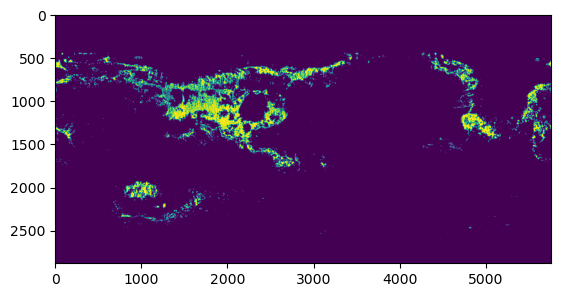

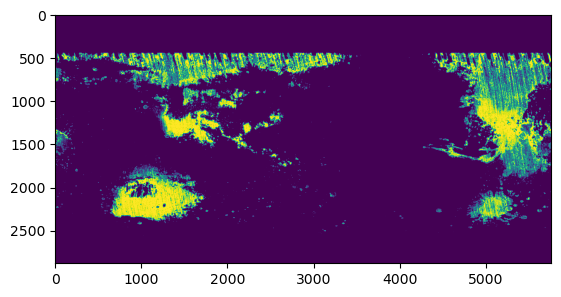

In [20]:
plt.imshow(elev_mask & ti_mask & alb_mask & dci_mask)
plt.show()
plt.imshow(elev_mask & alt_mask & dci_mask)
plt.show()

#### Spatial filters

In [21]:
# convert given latitude to absolute measure
def absolute_latitude(latitude):
    # positive: find distance from top
    if latitude > 0:
        return 90 - latitude
    # negative: find cumulative distance from top
    else:
        return abs(latitude) + 90

In [22]:
# find image's vertical interval equivalent to a latitudinal slice
def latitude_intervals(bottom, top, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 180

    # convert latitudes
    new_bottom = absolute_latitude(bottom) * factor
    new_top = absolute_latitude(top) * factor

    # remove rounding errors
    return (round(new_bottom), round(new_top))

In [23]:
# generate the boolean latitude mask
def latitude_mask(bottom, top, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_bottom, new_top) = latitude_intervals(bottom, top, dim_x)

    # iterate over latitude interval to make mask
    for x in range(new_top, new_bottom, 1):
        for y in range(len(base_mask[0])):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [24]:
# convert given longitude to absolute measure
def absolute_longitude(longitude):
    # positive: find distance from top
    if longitude > 0:
        return 180 + longitude
    # negative: find cumulative distance from top
    else:
        return 180 - abs(longitude)

In [25]:
# find image's vertical interval equivalent to a latitudinal slice
def longitude_intervals(left, right, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 360

    # convert latitudes
    new_left = absolute_longitude(left) * factor
    new_right = absolute_longitude(right) * factor
    
    # remove rounding errors
    return (round(new_left), round(new_right))

In [26]:
# generate the boolean latitude mask
def longitude_mask(left, right, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_left, new_right) = longitude_intervals(left, right, dim_y)

    # iterate over latitude interval to make mask
    for x in range(len(base_mask)):
        for y in range(new_left, new_right + 1, 1):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [27]:
# example mask: -30deg South, 60deg North
lat_mask = latitude_mask(-30, 60, 2880, 5760)

# example mask: -90deg West, 90deg East
lon_mask = longitude_mask(-90, 90, 2880, 5760)

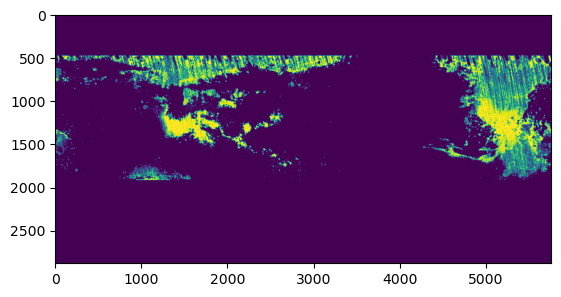

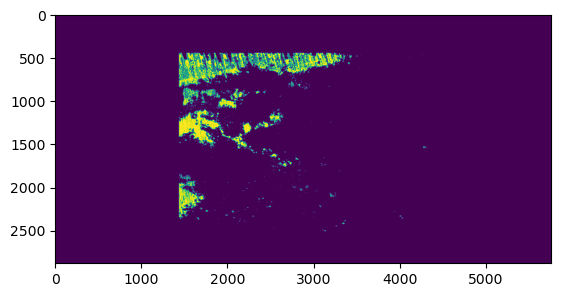

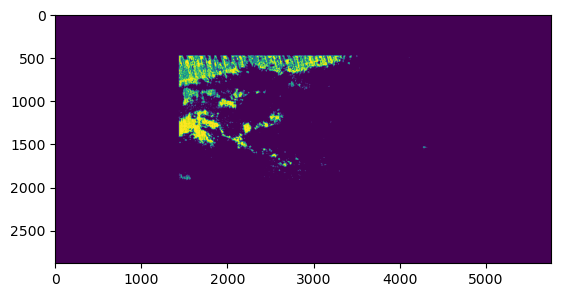

In [28]:
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lon_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask & lon_mask)
plt.show()

In [29]:
# actual lat mask for usage
# 10deg South, 10deg North
lat_mask = latitude_mask(-10, 10, 2880, 5760)

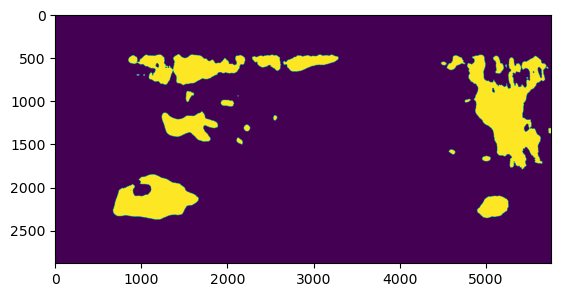

In [30]:
import cv2
rad=101
# im = elev_mask & alt_mask & dci_mask & lat_mask
im = elev_mask & alt_mask & dci_mask
im = np.uint8(255*im)
#cv2.imshow("",im)
#cv2.waitKey()
im = cv2.medianBlur(im, rad)

plt.imshow(im)
plt.show()

im = cv2.medianBlur(im, rad)

In [31]:
from scipy.signal import fftconvolve

# masked_TES = TES*(elev_mask & alt_mask & dci_mask & lat_mask & (TES>-1))
# masked_TES = TES*(im & lat_mask & (TES>-1))
masked_TES = TES*(elev_mask & alt_mask & dci_mask & (TES>-1))

# essentially a low pass filter
kernel = np.ones((101, 101), np.float32)

heatmap = fftconvolve(masked_TES, kernel, mode="same")

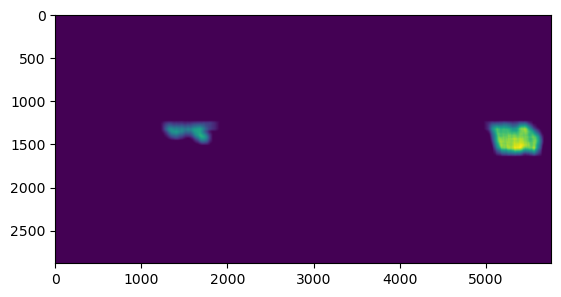

In [32]:
plt.imshow(heatmap)

### Level Set Region Segmentation

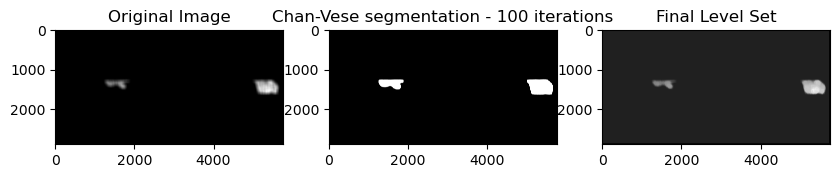

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# source img is prior heatmap
sampled_img = heatmap
gray_heatmap = sampled_img
num_iter = 1000

# chan-vese segmentation for heatmap contours
# chanvese_output = chan_vese(gray_heatmap, mu=0.25, lambda1=1, lambda2=1, tol=1e-10,
#                max_num_iter=200, dt=0.5, extended_output=True)
chanvese_output = chan_vese(gray_heatmap, max_num_iter=num_iter, extended_output=True)

ax = axes.flatten()

# original image
ax[0].imshow(gray_heatmap, cmap="gray")
ax[0].set_title("Original Image")

# segmented image
ax[1].imshow(chanvese_output[0], cmap="gray")
title = f"Chan-Vese segmentation - {num_iter} iterations"
format(len(chanvese_output[2]))

ax[1].set_title(title)

# level set
ax[2].imshow(chanvese_output[1], cmap="gray")
ax[2].set_title("Final Level Set")
plt.show()


In [53]:
mask = chanvese_output[0]

all_polygons = []
for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
    all_polygons.append(shapely.geometry.shape(shape))

all_polygons = shapely.geometry.MultiPolygon(all_polygons)
if not all_polygons.is_valid:
    all_polygons = all_polygons.buffer(0)
    if all_polygons.type == 'Polygon':
        all_polygons = shapely.geometry.MultiPolygon([all_polygons])

polygons = all_polygons

In [55]:
# # NOTE: this method is for preserving the multipolygon from earlier (use it if computation takes forever!)
# # save mutipolygon
# with open('./regions_multipolygon', "wb") as poly_file:
#     pickle.dump(polygons, poly_file, pickle.HIGHEST_PROTOCOL)

# # load multipolygon
# with open('./regions_multipolygon', "rb") as poly_file:
#     loaded_polygon = pickle.load(poly_file)

My loaded polygon: 
 MULTIPOLYGON (((1652 1249, 1751 1249, 1751 1250, 1757 1250, 1757 1249, 1816 1249, 1816 1250, 1832 1250, 1832 1251, 1847 1251, 1847 1252, 1856 1252, 1856 1253, 1862 1253, 1862 1254, 1868 1254, 1868 1255, 1873 1255, 1873 1256, 1877 1256, 1877 1257, 1880 1257, 1880 1258, 1881 1258, 1881 1260, 1882 1260, 1882 1266, 1883 1266, 1883 1317, 1882 1317, 1882 1322, 1881 1322, 1881 1324, 1880 1324, 1880 1326, 1879 1326, 1879 1328, 1878 1328, 1878 1329, 1876 1329, 1876 1330, 1874 1330, 1874 1331, 1872 1331, 1872 1332, 1870 1332, 1870 1333, 1867 1333, 1867 1334, 1864 1334, 1864 1335, 1860 1335, 1860 1336, 1855 1336, 1855 1337, 1846 1337, 1846 1338, 1833 1338, 1833 1339, 1827 1339, 1827 1340, 1823 1340, 1823 1341, 1820 1341, 1820 1342, 1818 1342, 1818 1343, 1816 1343, 1816 1344, 1814 1344, 1814 1345, 1813 1345, 1813 1346, 1811 1346, 1811 1347, 1810 1347, 1810 1348, 1809 1348, 1809 1349, 1808 1349, 1808 1351, 1807 1351, 1807 1352, 1806 1352, 1806 1354, 1805 1354, 1805 1356, 1804 1

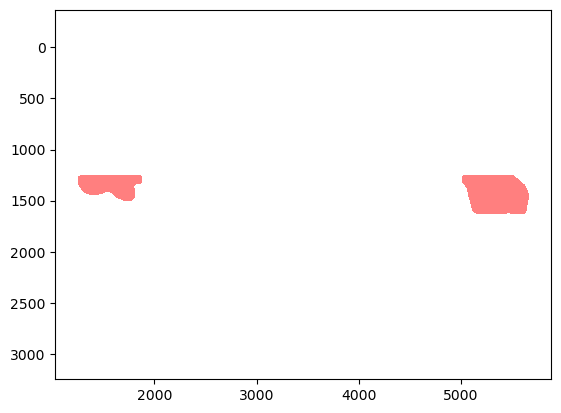

In [57]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

# for geom in loaded_polygon.geoms:
for geom in polygons.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

axs.invert_yaxis()

plt.show()

In [58]:
# sample 8 points from Multipolygonal geometry
points = sample(polygons, 8)

In [59]:
# convert coordinate to a [-dim/2, +dim/2] scaled domain
def relative_coordinate(position, dim):
    dim_origin = dim/2
    if position > dim_origin:
        return position - dim_origin
    else:
        return -dim_origin + position

In [60]:
# convert y points
def convert_coordinates(source_points, source_dim, destination_dim):
    conversion_factor = destination_dim / source_dim
    new_points = [relative_coordinate(point * conversion_factor, destination_dim) for point in source_points]
    return new_points

In [61]:
# separate points by axis
points_geoms = points
new_x = [geom[0] for geom in points_geoms]
new_y = [geom[1] for geom in points_geoms]

# conversion of points domain
sample_x = convert_coordinates(new_x, 5760, 360)
sample_y = [-1 * val for val in convert_coordinates(new_y, 2880, 180)]

In [62]:
# also, get the points from our Mars landing sites JSON
old_sites_path = './test_data/marsjson.json'
old_sites_file = open(old_sites_path)
old_sites = json.load(old_sites_file)

old_x = []
old_y = []

for site in old_sites:
    old_x.append(relative_coordinate(site["Longitude"], 360))
    old_y.append(site["Latitude"])

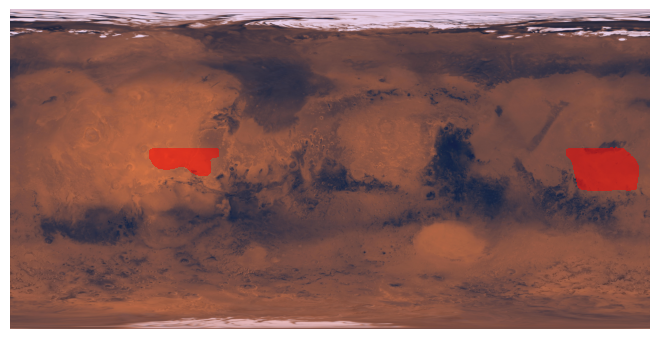

In [63]:
from matplotlib.transforms import Bbox
w = 5760
h=2880

fig, axs = plt.subplots()
# axs.set_aspect('equal', 'datalim')

img = plt.imread('test_data/Mars_Viking_ClrMosaic_global_925m_downscaled.jpg')

for geom in polygons.geoms:
# for geom in loaded_polygon.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

axs.imshow(img)
# axs.scatter(new_x,new_y,color='blue')
# axs.set_axis_off()
# axs.margins(0)

axs.axis("off")

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig("regions_basemap.png", transparent = True, bbox_inches = 'tight', pad_inches=0)

### Display: Rotating Mars

In [64]:
# generate longitudinal views for rotation (must be an evenly-divisible integer with 360 as dividend)
no_views = 24
all_views = [[x,0] for x in range(-180,180 + 1,no_views)]

# TEST: generate a set of 100 points to check if plotting works as expected
# test_x = random.sample(range(-180, 180 + 1), 10)
# test_y = random.sample(range(-90, 90 + 1), 10)

# source of basemap
# img = plt.imread('./test_data/Mars_Viking_ClrMosaic_global_925m_downscaled.jpg')
img = plt.imread('./regions_basemap.png')

# plot for each possible views
for idx, current_view in enumerate(all_views):
    # view config
    save_name = f"./figures/mars_view_{idx}"
    title_name = f"Lat.: {current_view[0]}, Lon: {current_view[1]}"

    # set source, dest coordinate reference system (type of map)
    data_crs = ccrs.PlateCarree()
    projection = ccrs.Orthographic(*current_view)

    # init plot
    fig = plt.figure(figsize = (6,6))
    ax  = plt.axes(projection = projection)

    # plot the map + points
    # TODO: add latitudes of constraint
    ax.imshow(img, extent = [-180, 180, -90, 90], transform = data_crs, interpolation='spline36')
    ax.scatter(old_x,old_y,transform=ccrs.Geodetic(),color='white')
    ax.scatter(sample_x,sample_y,transform=ccrs.Geodetic(),color='blue')
    ax.set_axis_off()

    # save plot
    plt.title(title_name, fontweight='bold')
    plt.savefig(save_name)
    plt.close()

In [65]:
# interpolate all views into gif
frames = []
no_views = 24
time = int(360/no_views) + 1;

# stitch all frames together
for t in range(time):
    image = imageio.v2.imread(f'./figures/mars_view_{t}.png')
    frames.append(image)

# save resultant gif
imageio.mimsave('./rotating_mars.gif', frames, fps = 1.5)

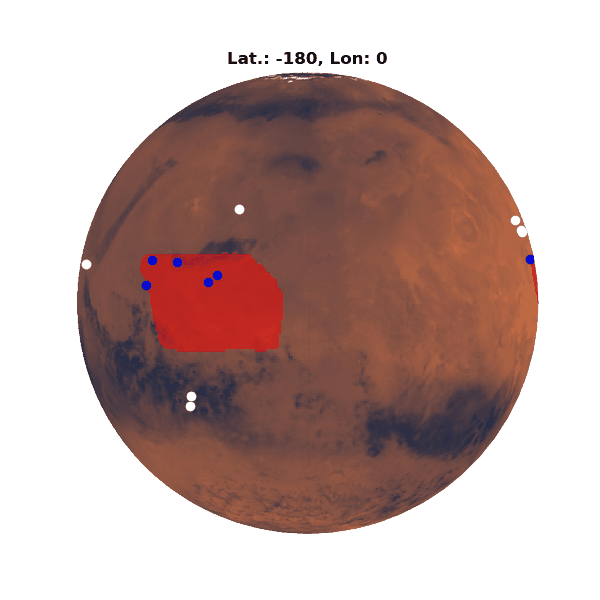

In [66]:
from IPython.display import Image

Image(open('./rotating_mars.gif','rb').read())